

# Hyperparameters, GridSearch, and Pipelines


---

![](https://snag.gy/aYcCt2.jpg)

### Learning Objectives
- Describe what the terms hyperparameters, GridSearch, and pipeline mean.
- Apply `sklearn`'s `GridSearchCV` object.
- Use attributes of the GridSearch object.
- Describe the pitfalls of searching large hyperparameter spaces.
- Build pipelines.

In [ ]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [ ]:
# Read in data.
un_data = pd.read_csv('./data/UNdata.csv')

# Examine first five rows.
un_data.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


In [ ]:
un_data[un_data['country']=='Singapore']

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
151,Singapore,Asia,75.1,79.5,5,25581


In [ ]:
un_data[un_data['country']=='Russia']

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
142,Russia,Europe,58.0,71.5,19,2451


In [ ]:
un_data[un_data['country']=='India']

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
74,India,Asia,62.1,62.7,72,365


## United Nations Data

- `country`: the name of the nation
- `region`: the region of the world (Africa, America, Asia, Europe, Oceania)
- `lifeMale`: the life expectancy of males
- `lifeFemale`: the life expectancy of females
- `infantMortality`: the infant mortality rate (generally reported per 1,000 live births)
- `GDPperCapita`: the Gross Domestic Product per person

In [ ]:
# Check for missing values.
un_data.isnull().sum()



country            0
region             0
lifeMale           0
lifeFemale         0
infantMortality    0
GDPperCapita       0
dtype: int64

In [ ]:
un_data.head()

,country,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
0,Afghanistan,Asia,45.0,46.0,154,2848
1,Albania,Europe,68.0,74.0,32,863
2,Algeria,Africa,67.5,70.3,44,1531
3,Angola,Africa,44.9,48.1,124,355
4,Argentina,America,69.6,76.8,22,8055


In [ ]:
# Set country to be the index.
un_data.set_index('country', inplace = True)

In [ ]:
un_data.head()

,region,lifeMale,lifeFemale,infantMortality,GDPperCapita
country,,,,,
Afghanistan,Asia,45.0,46.0,154,2848
Albania,Europe,68.0,74.0,32,863
Algeria,Africa,67.5,70.3,44,1531
Angola,Africa,44.9,48.1,124,355
Argentina,America,69.6,76.8,22,8055


In [ ]:
un_data = pd.get_dummies(un_data, columns = ['region'], drop_first = True)

In [ ]:
un_data.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania
country,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0
Albania,68.0,74.0,32,863,0,0,1,0
Algeria,67.5,70.3,44,1531,0,0,0,0
Angola,44.9,48.1,124,355,0,0,0,0
Argentina,69.6,76.8,22,8055,1,0,0,0


In [ ]:
# Dummy region.


<details><summary>What is our reference category for this dummy variable?</summary>

- Africa!
- There is no dummy variable for Africa in our data, meaning that all dummy variables would be interpreted **relative to Africa**.
</details>

### Create $Y$ variable

In [ ]:
# Create a column with 1 if the female life expectancy is greater
# than the male life expectancy.
un_data['females_are_strong_as_hell'] = (un_data['lifeFemale']>un_data['lifeMale']).astype(int)

# The column name is a reference to the 
# Netflix series "The Unbreakable Kimmy Schmidt."

In [ ]:
un_data.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania,females_are_strong_as_hell
country,,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0,1
Albania,68.0,74.0,32,863,0,0,1,0,1
Algeria,67.5,70.3,44,1531,0,0,0,0,1
Angola,44.9,48.1,124,355,0,0,0,0,1
Argentina,69.6,76.8,22,8055,1,0,0,0,1


In [ ]:
# What should we check next?

un_data['females_are_strong_as_hell'].value_counts(normalize=True)


1    0.989362
0    0.010638
Name: females_are_strong_as_hell, dtype: float64

<details><summary>Do you have any concerns about the above?</summary>
    
- Our classes are severely unbalanced.
- We should check out our tools for handling unbalanced classes. (e.g. moving our classification threshold, implement stratified $k$-fold cross-validation)
- Given the relatively low sample size and the small number of the observations in the minority category here, it is unlikely that our model would be able to predict that a nation has a higher male life expectancy.
</details>

In [ ]:
# Create a column with 1 if the female life expectancy is 5
# or more years longer than the male life expectancy.
un_data['females_are_strong_as_hell'] = (un_data['lifeFemale'] >= (un_data['lifeMale'] + 5)).astype(int)

# Check the thing we need to check!
un_data['females_are_strong_as_hell'].value_counts(normalize=True)

0    0.569149
1    0.430851
Name: females_are_strong_as_hell, dtype: float64

**We are interested in predicting whether or not the female life expectancy of a nation is at least five years greater than the male life expectancy.** This is a classification problem.

### Create the training and testing data

In [ ]:
# Set up X and y.
X = un_data.drop(['females_are_strong_as_hell', 'lifeMale', 'lifeFemale'], axis = 'columns')
y = un_data['females_are_strong_as_hell']

In [ ]:
# Split our data into training and testing sets.

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42,
                                                    stratify = y) # Note the stratify argument here!

In [ ]:
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

0    0.568
1    0.432
Name: females_are_strong_as_hell, dtype: float64
0    0.571429
1    0.428571
Name: females_are_strong_as_hell, dtype: float64


<details><summary>Before we fit a k-Nearest Neighbors model, what do we need to do? Why?</summary>
    
- Standardize our data!
- If we *don't* standardize our data, then features that have larger spreads (e.g. higher ranges or higher standard deviations) will have a disproportionate influence on our model.
- If all of your variables are already on the same scale, then scaling is not necessary.
</details>

In [ ]:
un_data.head()

,lifeMale,lifeFemale,infantMortality,GDPperCapita,region_America,region_Asia,region_Europe,region_Oceania,females_are_strong_as_hell
country,,,,,,,,,
Afghanistan,45.0,46.0,154,2848,0,1,0,0,0
Albania,68.0,74.0,32,863,0,0,1,0,1
Algeria,67.5,70.3,44,1531,0,0,0,0,0
Angola,44.9,48.1,124,355,0,0,0,0,0
Argentina,69.6,76.8,22,8055,1,0,0,0,1


In [ ]:
# Instantiate.
ss = StandardScaler()

# Fit and transform.
 
X_train_sc = ss.fit_transform(X_train)


# Transform.
X_test_sc = ss.transform(X_test)

## Fit the Default kNN

Below we fit a default `KNeighborsClassifier` to predict `y`. ([Here is the documentation.](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html))

<details><summary>What is the default number of neighbors used in kNN?</summary>
    
- 5.
</details>

In [ ]:
# Instantiate.
knn = KNeighborsClassifier()

# Fit.

knn.fit(X_train_sc,y_train)

KNeighborsClassifier()

In [ ]:
# Evaluate.
knn.score(X_test_sc,y_test)


0.7619047619047619

In [ ]:
knn.score(X_train_sc,y_train)

0.848

<details><summary>What score is this?</summary>

- Accuracy.
</details>

In [ ]:
# Evaluate against the baseline.


<details><summary>Is selecting k = 5 a good choice? Is it the best choice?</summary>

- We don't know!
- $k$ is a hyperparameter.
</details>

## What are "hyperparameters?"

Models often have built-in quantities that we can use to fine-tune our results. 
- What value of $k$ do we select?
- What distance metric do we select?
- Do we use LASSO or Ridge regularization?
- What value of $\alpha$ or $C$ do we use?

These are quantities our model **cannot** learn... **we must decide on these ourselves**!

> These are different from statistical parameters, which are quantities a model _can_ learn.

However, different values for hyperparameters can result in substantially different models. 
- Let's [visualize fits for different values of $k$](http://scott.fortmann-roe.com/docs/BiasVariance.html) in $k$-nearest neighbors.

<details><summary>We want to find the optimal values for our hyperparameters. How do you think we might do this?</summary>

- Try many different values of hyperparameters and see which ones perform the best on our data.
</details>

## Searching for the Best Hyperparameters

Our default kNN performs quite poorly on the test data. But what if we changed the number of neighbors? The weighting? The distance metric?

These are all hyperparameters of kNN. How would we do this manually? We would need to evaluate on the training data the set of hyperparameters that perform best, and then use this set of hyperparameters to fit the final model and score on the testing set.

**One method of searching for the optimal set of hyperparameters is called GridSearching.**

GridSearching gets its name from the fact that we are searching over a "grid" of hyperparameters. For example, imagine the `n_neighbors` hyperparameters as the columns and `weights` as the rows. This makes a grid. We check the accuracy for all combinations of hyperparameters on the grid.

![](./images/grid.jpg)

### Using `GridSearchCV`

This would be an annoying process to have to do manually. Luckily `sklearn` comes in handy:

```python
from sklearn.model_selection import GridSearchCV
```

The `GridSearchCV` has a handful of important arguments:

| Argument | Description |
| --- | ---|
| **`estimator`** | The sklearn instance of the model to fit on |
| **`param_grid`** | A dictionary where keys are hyperparameters for the model and values are lists of values to test |
| **`cv`** | The number of internal cross-validation folds to run for each set of hyperparameters |
| **`n_jobs`** | How many cores to use on your computer to run the folds (-1 means use all cores) |
| **`verbose`** | How much output to display (0 is none, 1 is limited, 2 is printouts for every internal fit) |


Below is an example for how one might set up the GridSearch for our kNN:

```python
knn_parameters = {
    'n_neighbors':[2,3],
    'weights':['uniform','distance'],
    'p':[1,2]
}

knn_gridsearcher = GridSearchCV(KNeighborsClassifier(), knn_parameters, verbose=1)
knn_gridsearcher.fit(X_train, y_train)
```

**Try out the `sklearn` GridSearch below on the training data.** [You can find the GridSearchCV documentation here.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [ ]:
# Create dictionary of hyperparameters.
# The keys MUST match the names of the arguments!
knn_params = {
    'n_neighbors': range(1, 51, 10),
    'metric': ['euclidean', 'manhattan']
}

In [ ]:
# Instantiate our GridSearchCV object.
knn_gridsearch = GridSearchCV( KNeighborsClassifier()  # What is the model we want to fit?
                              , knn_params # What is the dictionary of hyperparameters?
                              , cv = 5 # What number of folds in CV will we use?
                              , verbose=1)

In [ ]:
# Fit the GridSearchCV object to the data
knn_gridsearch.fit (X_train_sc, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 51, 10)},
             verbose=1)

### Examining the Results of the GridSearch

Once the GridSearch has fit (this can take awhile!) we can pull out a variety of information and useful objects from the GridSearch object, stored as attributes:

| Property | Description |
| --- | ---|
| **`results.param_grid`** | Displays hyperparameters searched over. |
| **`results.best_score_`** | Best mean cross-validated score achieved. |
| **`results.best_estimator_`** | Reference to model with best score.  Is usable / callable. |
| **`results.best_params_`** | The hyperparameters that have been found to perform with the best score. |
| **`results.grid_scores_`** | Display score attributes with corresponding hyperparameters. | 

In [ ]:
# Print out the score.
# from documentation: Mean cross-validated score of the best_estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

knn_gridsearch.best_score_

0.784

In [ ]:
# Print out the set of hyperparameters that achieved the best score.
knn_gridsearch.best_params_

{'metric': 'euclidean', 'n_neighbors': 1}

In [ ]:
# Evaluate the best fit model on the test data.

knn_gridsearch.score(X_test_sc,y_test)


0.7619047619047619

In [ ]:
knn_gridsearch.score(X_train_sc,y_train)

1.0

**Let's see everything!**

In [ ]:
pd.DataFrame(knn_gridsearch.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001736,0.001061,0.002356,0.000336,euclidean,1,"{'metric': 'euclidean', 'n_neighbors': 1}",0.76,0.84,0.92,0.72,0.68,0.784,0.086163,1
2,0.001199,0.000215,0.003170,0.000952,euclidean,21,"{'metric': 'euclidean', 'n_neighbors': 21}",0.84,0.84,0.76,0.72,0.72,0.776,0.054259,2
5,0.001320,0.000463,0.002409,0.000362,manhattan,1,"{'metric': 'manhattan', 'n_neighbors': 1}",0.76,0.84,0.92,0.72,0.64,0.776,0.096664,2
7,0.001225,0.000209,0.002666,0.000502,manhattan,21,"{'metric': 'manhattan', 'n_neighbors': 21}",0.84,0.84,0.76,0.72,0.72,0.776,0.054259,2
6,0.001214,0.000229,0.003635,0.000840,manhattan,11,"{'metric': 'manhattan', 'n_neighbors': 11}",0.84,0.84,0.68,0.64,0.68,0.736,0.086163,5


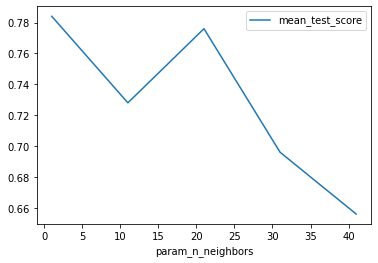

In [ ]:
gs_df = pd.DataFrame(knn_gridsearch.cv_results_)
gs_df = gs_df[gs_df['param_metric'] == 'euclidean']
gs_df.plot(x='param_n_neighbors', y='mean_test_score');

## A Word of Caution on GridSearching

`sklearn` models often have many hyperparameters with many different possible values. It may be tempting to search over a wide variety of them. In general, this is not wise.

<details><summary>Why not?</summary>

- Remember that GridSearch searches over **all possible combinations of hyperparameters in the parameter dictionary!**

Imagine that we had this as our parameter dictionary:

```python
parameter_grid = {
    'n_neighbors': range(1, 151),
    'weights': ['uniform', 'distance', custom_function],
    'algorithm': ['ball_tree', 'kd_tree', 'brute', 'auto'],
    'leaf_size': range(1, 152),
    'metric': ['minkowski', 'euclidean'],
    'p': [1, 2]
}
```

**How many different combinations will need to be tested?**

| Parameter | Number of Chosen Values |
| --- | --- |
| **n_neighbors** | 150 |
| **weights** | 3 |
| **algorithm** | 4 |
| **leaf_size** | 151 |
| **metric** | 2 |
| **p** | 2 |
| <br>_150 \* 3 \* 4 \* 151 \* 2 \* 2 = n combinations_ <br><br>| _1,087,200_ |

If we select `cv = 5`, we would fit 1,087,200 models on five folds, meaning we fit 5,436,000 models!

If you're not careful, GridSearching can quickly scale out of hand computationally.

> **It is extremely important to understand what the hyperparameters do and think critically about what ranges are useful and relevant to your model!**
</details>

## A brief detour: estimators and transformers.
**Estimators** and **transformers** are two types of classes in `sklearn`.

We've seen several examples of each so far.

### Scikit-Learn Estimators
Estimators are essentially _models_. They fit this format:

```python
# Instantiate.
model = LinearRegression(params)
# Fit.
model.fit(X_train, y_train)
# Predict.
y_pred = model.predict(X_test)
```

Estimators have a **fit** and **predict** method.

### Scikit-Learn Transformers
Transformers are not models. They transform your data using similar syntax to estimators. They work like this:

```python
# Instantiate.
ss = StandardScaler(params)
# Fit.
ss.fit(X_train)
# Transform.
X_transformed = ss.transform(X_train)
```

Instead of `fit` and `predict`, they have **fit** and **transform** methods. In fact, since you fit and transform together so often, they have a shortcut:

```python
ss = StandardScaler(params)
X_transformed = ss.fit_transform(X_train)
```

We've seen a few transformers, including `StandardScaler()` and `PolynomialFeatures()`. There's also `OneHotEncoder()` for dummy encoding and `LabelEncoder()` for factorizing variables. Later we'll see `PCA()`, which is also a transformer.

### Why is this relevant?

Check out the [StandardScaler documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Transformers may have hyperparameters as well - **but we can't GridSearch over a transformer**! There's no way to get an accuracy (or other) score from just a transformer, since a transformer can't predict!


![](./images/grid.jpg)

In addition, the acronym ETL, meaning "extract, transform, load," is a very common one in data science. When we gather data from one or more places, there might be **a lot** of preprocessing going on.

Oftentimes, we'll want to apply several transformers to a dataset, *then* build a model. 
- If you do all of these preprocessing steps independently, your code can be messy and it'll be prone to errors!
- It can be challenging to consistently recreate this process.

## Pipelines
![](./images/pipe.png)

Pipelines will allow us to do two things:
1. Chain many transformers together before ending in an estimator.
2. Allow us to GridSearch over a transformer's hyperparameters.

In [ ]:
# Instantiate a StandardScaler + kNN pipeline.
pipe = Pipeline([ 
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Fit.

pipe.fit(X_train, y_train)


Pipeline(steps=[('ss', StandardScaler()), ('knn', KNeighborsClassifier())])

In [ ]:
# Evaluate.

pipe.score(X_test, y_test)


0.7619047619047619

In [ ]:
# Get params - yes, you can GridSearchCV over these!
# Notice the naming convention of pipe arguments.

pipe.get_params()

{'memory': None,
 'steps': [('ss', StandardScaler()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'ss': StandardScaler(),
 'knn': KNeighborsClassifier(),
 'ss__copy': True,
 'ss__with_mean': True,
 'ss__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [ ]:
# Instantiate pipeline object.
pipe_2 = Pipeline([
    ('knn', KNeighborsClassifier()),
    ('ss', StandardScaler())
])

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' 'KNeighborsClassifier()' (type <class 'sklearn.neighbors._classification.KNeighborsClassifier'>) doesn't

In [ ]:
# Define dictionary of hyperparameters.
pipe_2_params = {
    'ss__with_mean': [True,False],
    'ss__with_std': [True,False],
    'knn__p': [1,2],
    'knn__n_neighbors': [3,5,10],
    'knn__weights': ['uniform','distance']
}

In [ ]:
# Instantiate our GridSearchCV object.
pipe_2_gridsearch = GridSearchCV(pipe_2, # What is the model we want to fit?
                                 pipe_2_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1)

In [ ]:
# Fit the GridSearchCV object to the data.
pipe_2_gridsearch.fit(X_train, y_train);

In [ ]:
# Print out best score.
# from documentation: Mean cross-validated score of the best_estimator
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

pipe_2_gridsearch.best_score_

In [ ]:
# Print out best estimator.
pipe_2_gridsearch.best_estimator_

In [ ]:
# Evaluate the best model on the test data.
pipe_2_gridsearch.score(X_test,y_test)

<details><summary>What would you conclude from this output?</summary>
    
- Our model performs slightly better when cross-validated on our training data than on our testing data, but the difference is pretty small.
- There may be slight overfitting.
- GridSearching gets us the best performing model on the training set; we always have to take care to not overfit!
</details>

## Interview Question

<details><summary>What is the difference between hyperparameters and statistical parameters?</summary>
    
- Statistical parameters are quantities that a model can learn or estimate. Examples include $\beta_0$ and $\beta_1$ in a linear model.
- Hyperparameters are quantities our model cannot learn, but affect the fit of our model. Examples include $k$ in $k$-nearest neighbors and $alpha$ in regularization.
</details>

## (BONUS) RandomizedSearchCV + Visualizing Results

When you're exploring a particularly high number of different hyperparameters, it can be advantageous to do a randomized search instead of a GridSearch.

`from sklearn.model_selection import RandomizedSearchCV`

A good blog post on GridSearch, RandomizedSearch, and visualizing the outputs of these methods [can be found here](https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9).

Another good example on RandomizedSearch [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/17_randomized_search.ipynb).

## (BONUS) make_pipeline

`make_pipeline` does the same thing as `pipeline`, but does not require you to name your steps!

`from sklearn.pipeline import make_pipeline`

See an explanation of the difference between the two [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/12_pipeline_vs_make_pipeline.ipynb) and see an example of it used [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/08_pipeline.ipynb).

## (BONUS) Named Steps

GridSearch not giving you all of the information you need? Want to see what is happening in the intermediate steps in a pipeline? Use the `named_steps` attribute! An example of how to use this can be found [here](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/13_examine_pipeline_steps.ipynb).